# Question generation tests
Let's test how well we can generate questions for the "clean" CNN data with crowdsourced questions and the noisy NYT data with user-generated questions.

In [1]:
## load data
import pandas as pd
import os
import re
cnn_article_dir = '../../data/CNN_articles/cnn/stories/'
cnn_article_files = list(map(lambda x: os.path.join(cnn_article_dir, x), os.listdir(cnn_article_dir)))
cnn_article_data = pd.DataFrame(list(map(lambda x: ' '.join(list(map(lambda x: x.strip(), open(x, 'r').readlines()))), cnn_article_files)),
                                columns=['article_text'])
article_id_matcher = re.compile('[a-z0-9]+(?=\.story)')
cnn_article_ids = list(map(lambda x: article_id_matcher.search(x).group(0), cnn_article_files))
cnn_article_data = cnn_article_data.assign(**{
    'article_id' : cnn_article_ids
})
display(cnn_article_data.head())

,article_text,article_id
0,(CNN) -- It's been a busy few days in the worl...,23f7ab281ef416e1cdcd9c6fc359278a40a6ba34
1,Ten loveable mutts rescued from the streets of...,a8ac73078f8774a5addac799a22d0634278e79d1
2,Ken Henggeler poured his grief into the thing ...,022713fd20ac0ffd0ddccec6d9389beedd681893
3,Tokyo (CNN) -- Japan's prime minister vowed to...,d62d6364625d1522c55024486ec25851687935e3
4,(CNN) -- The leadership of North Korea appeare...,911597eecfe5d00d39de94f17c2a8400fcb4b994


In [2]:
cnn_question_file = '../../data/CNN_articles/cnn/newsqa-data-v1/newsqa-data-v1.csv'
full_cnn_question_data = pd.read_csv(cnn_question_file, sep=',', index_col=False, usecols=['story_id', 'question', 'is_answer_absent', 'is_question_bad', 'answer_char_ranges'])
full_cnn_question_data.rename(columns={'story_id' : 'article_id'}, inplace=True)
# get article IDs
cnn_article_id_matcher = re.compile('[0-9a-zA-Z]+(?=\.story)')
full_cnn_question_data = full_cnn_question_data.assign(**{
    'article_id' : full_cnn_question_data.loc[:, 'article_id'].apply(lambda x: cnn_article_id_matcher.search(x).group(0))
})
# clean answers
full_cnn_question_data = full_cnn_question_data.assign(**{
    'answer_char_ranges' : full_cnn_question_data.loc[:, 'answer_char_ranges'].apply(lambda x: list(filter(lambda x: x!='None', x.split('|')))),
})

def extract_char_range(txt):
    txt_splits = txt.split(',')
    char_range = list(map(lambda x: list(map(lambda y: int(y), x.split(':'))), txt_splits))
    return char_range
def extract_all_char_ranges(txt):
    char_ranges = list(map(lambda y: extract_char_range(y), txt))
    # flatten lol
    flat_char_ranges = []
    for char_range_i in char_ranges:
        flat_char_ranges += char_range_i
    return flat_char_ranges
full_cnn_question_data = full_cnn_question_data.assign(**{
    'clean_answer_char_ranges' : full_cnn_question_data.loc[:, 'answer_char_ranges'].apply(lambda x: extract_all_char_ranges(x)),
})
# get rid of unclear questions
# NOTE: we may need the different "bad" ratings later when testing word overlap
full_cnn_question_data = full_cnn_question_data[full_cnn_question_data.loc[:, 'is_question_bad']!='?']
full_cnn_question_data = full_cnn_question_data.assign(**{'is_question_bad' : full_cnn_question_data.loc[:, 'is_question_bad'].astype(float)})
# remove bad questions
cnn_question_data = full_cnn_question_data[(full_cnn_question_data.loc[:, 'is_answer_absent']==0.) &
                                           (full_cnn_question_data.loc[:, 'is_question_bad']==0.)]
display(cnn_question_data.head())


,article_id,question,answer_char_ranges,is_answer_absent,is_question_bad,clean_answer_char_ranges
0,42d01e187213e86f5fe617fe32e716ff7fa3afc4,What was the amount of children murdered?,[294:297],0.0,0.0,"[[294, 297]]"
1,c48228a52f26aca65c31fad273e66164f047f292,Where was one employee killed?,"[34:60, 1610:1618, 34:60]",0.0,0.0,"[[34, 60], [1610, 1618], [34, 60]]"
2,c65ed85800e4535f4bbbfa2c34d7d9630358d303,who did say South Africa did not issue a visa ...,"[103:127, 114:127, 839:853]",0.0,0.0,"[[103, 127], [114, 127], [839, 853]]"
3,0cf66b646e9b32076513c050edf32a799200c3c2,How many years old was the businessman?,"[538:550, 538:550]",0.0,0.0,"[[538, 550], [538, 550]]"
4,13012604e3203c18df09289dfedd14cde67cf40b,What frightened the families?,"[690:742, 688:791, 630:646]",0.0,0.0,"[[690, 742], [688, 791], [630, 646]]"


In [3]:
## combine article/comment
cnn_article_question_data = pd.merge(cnn_question_data, cnn_article_data, on='article_id')
cnn_article_question_data = cnn_article_question_data[~cnn_article_question_data.loc[:, 'article_text'].apply(lambda x: type(x) is float and np.isnan(x))]
## get answers to validate questions
cnn_article_question_data = cnn_article_question_data.assign(**{
    
})
cnn_article_question_data = cnn_article_question_data.assign(**{
    'clean_answers' : cnn_article_question_data.apply(lambda x: list(map(lambda y: x.loc['article_text'][y[0]:y[1]], x.loc['clean_answer_char_ranges'])), axis=1)
})

In [4]:
print(f'{cnn_article_question_data.shape[0]} questions')

63672 questions


In [5]:
display(cnn_article_question_data.head(5))

,article_id,question,answer_char_ranges,is_answer_absent,is_question_bad,clean_answer_char_ranges,article_text,clean_answers
0,42d01e187213e86f5fe617fe32e716ff7fa3afc4,What was the amount of children murdered?,[294:297],0.0,0.0,"[[294, 297]]","NEW DELHI, India (CNN) -- A high court in nort...",[ict]
1,42d01e187213e86f5fe617fe32e716ff7fa3afc4,When was Pandher sentenced to death?,"[261:271, 258:271, 261:271]",0.0,0.0,"[[261, 271], [258, 271], [261, 271]]","NEW DELHI, India (CNN) -- A high court in nort...","[bruary. T, February. T, bruary. T]"
2,42d01e187213e86f5fe617fe32e716ff7fa3afc4,The court aquitted Moninder Singh Pandher of w...,"[26:33, 624:640]",0.0,0.0,"[[26, 33], [624, 640]]","NEW DELHI, India (CNN) -- A high court in nort...","[A high , murder of the 1]"
3,42d01e187213e86f5fe617fe32e716ff7fa3afc4,who was acquitted,"[195:218, 195:218]",0.0,0.0,"[[195, 218], [195, 218]]","NEW DELHI, India (CNN) -- A high court in nort...","[ninder Singh Pandher wa, ninder Singh Pandher..."
4,42d01e187213e86f5fe617fe32e716ff7fa3afc4,What was Moninder Singh Pandher acquitted for?,"[129:192, 129:151, 133:151]",0.0,0.0,"[[129, 192], [129, 151], [133, 151]]","NEW DELHI, India (CNN) -- A high court in nort...","[the killing of a teen in a case dubbed ""the h..."


### Train model
Let's try an actual trained QA model with all the bells/whistles first, downloaded from [here](https://github.com/patil-suraj/question_generation.git).

In [6]:
import sys
if('question_generation/' not in sys.path):
    sys.path.append('question_generation/')
## NOTE need to run pipeline once to download (expensive!!) models
from pipelines import pipeline
# print(help(pipeline))
question_pipeline = pipeline('question-generation')

In [7]:
## test short text
text = "Python is an interpreted, high-level, general-purpose programming language. Created by Guido van Rossum \
and first released in 1991, Python's design philosophy emphasizes code \
readability with its notable use of significant whitespace."
text_question = question_pipeline(text)
print(text_question)

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/transformers/tokenization_t5.py:183: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(


[{'answer': 'Python', 'question': 'What is an interpreted, high-level, general-purpose programming language?'}, {'answer': 'Guido van Rossum', 'question': 'Who created Python?'}]


In [8]:
# test with article, which can be longer
test_cnn_article_question_data = cnn_article_question_data.iloc[0, :]
test_article = test_cnn_article_question_data.loc['article_text']
test_gold_question = test_cnn_article_question_data.loc['question']
print(f'{test_article[:300]}...')
test_article_questions = question_pipeline(test_article)
print(f'generated questions = {test_article_questions}')
print(f'gold question = {test_gold_question}')

NEW DELHI, India (CNN) -- A high court in northern India on Friday acquitted a wealthy businessman facing the death sentence for the killing of a teen in a case dubbed "the house of horrors."  Moninder Singh Pandher was sentenced to death by a lower court in February.  The teen was one of 19 victims...
generated questions = [{'answer': 'the house of horrors', 'question': 'What was the name of the case that was acquitted by a high court in northern India?'}, {'answer': 'February', 'question': 'When was Moninder Singh Pandher sentenced to death?'}, {'answer': '19', 'question': 'How many victims did Moninder Singh Pandher have?'}, {'answer': 'Sikandar B. Kochar', 'question': "Who was Moninder Singh Pandher's lawyer?"}, {'answer': 'Surinder Koli', 'question': "Who was Pandher's domestic employee?"}, {'answer': 'Koli', 'question': "Who's death sentence was upheld by the high court?"}, {'answer': 'Noida', 'question': "Where was Pandher's home found?"}, {'answer': 'house of horrors', 'questio

Even though the wording is different, we see that the gold question is captured in at least one of the generated questions (`How many victims...`).

### Generate, evalute questions for articles

Let's try generating questions for all the articles and see how potentially useful they would be. They may be restricted to within-sentence reasoning and therefore not too complicated.

In [51]:
from tqdm import tqdm
tqdm.pandas()
def generate_questions(text, question_model):
    questions = []
    try:
        questions = question_model(text)
    except Exception as e:
        print(f'no questions because error {e}')
    return questions
article_var = 'article_text'
cnn_article_data_with_questions = cnn_article_data[cnn_article_data.loc[:, 'article_id'].isin(cnn_article_question_data.loc[:, 'article_id'].values)]
import numpy as np
np.random.seed(123)
# sample_size = 500
sample_size = cnn_article_data_with_questions.shape[0]
sample_cnn_article_data_with_questions = cnn_article_data_with_questions.loc[np.random.choice(cnn_article_data_with_questions.index, sample_size, replace=False), :]
sample_cnn_article_generated_questions = sample_cnn_article_data_with_questions.loc[:, article_var].progress_apply(lambda x: generate_questions(x, question_pipeline))

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/tqdm/std.py:706: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
  0%|          | 12/11852 [00:16<5:03:36,  1.54s/it]/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/transformers/tokenization_t5.py:183: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(
 26%|██▌       | 3106/11852 [1:11:28<3:47:07,  1.56s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [66]:
# ## combine with other data 
# sample_cnn_article_generated_question_data = sample_cnn_article_generated_questions.reset_index(name='article_questions').drop('index', axis=1).assign(**{'article_id' : sample_cnn_article_data_with_questions.loc[:, 'article_id'].values})
# # display(sample_cnn_article_generated_question_data.head())
# sample_cnn_article_generated_question_data = pd.merge(sample_cnn_article_generated_question_data, cnn_article_question_data, on='article_id', how='left')
display(sample_cnn_article_generated_question_data.head())
## save to file
out_file = '../../data/CNN_articles/cnn/article_generated_question_data.tsv'
sample_cnn_article_generated_question_data.to_csv(out_file, sep='\t', index=False)

,article_questions,article_id,question,answer_char_ranges,is_answer_absent,is_question_bad,clean_answer_char_ranges,article_text,clean_answers,best_question_score,best_question
49617,"[{'answer': 'Stephen Hawking', 'question': 'Wh...",511fa443bdaabb7845aba2cb69737c96d7efd757,who is the world's greatest living scientist?,"[72:88, 72:88]",0.0,0.0,"[[72, 88], [72, 88]]","LONDON, England (CNN) -- Cosmologist, theoreti...","[Stephen Hawking , Stephen Hawking ]",1.0,who is the world's greatest living scientist?
17185,"[{'answer': '2-0', 'question': 'When did Inter...",b0a5fb32fb2d97a4ff49362a77aa7288914b44b6,who beat lazio 2-0?,"[10:22, 10:22]",0.0,0.0,"[[10, 22], [10, 22]]",(CNN) -- Inter Milan stayed on course for the...,"[Inter Milan , Inter Milan ]",1.0,who beat lazio 2-0?
17039,"[{'answer': 'Christmas Eve', 'question': 'When...",4872125bdb96f745b14fea0f09c3f3773e2fe551,who argued over gambling debt?,"[20:62, 288:326, 20:62]",0.0,0.0,"[[20, 62], [288, 326], [20, 62]]",Washington (CNN) -- Two Washington Wizards bas...,"[Two Washington Wizards basketball players , e...",1.0,who argued over gambling debt?
56153,"[{'answer': 'John Albert Gardner III', 'questi...",85a7aaa5b67a30872d4f47f0ec930465bfb442e8,what did gardner plead guilty to?,"[1609:1655,1743:1763,1766:1778, 368:378, 1743:...",0.0,0.0,"[[1609, 1655], [1743, 1763], [1766, 1778], [36...",(CNN) -- Admitted killer John Albert Gardner I...,[go-area teens in a deal with prosecutors that...,1.0,what did gardner plead guilty to?
47413,"[{'answer': 'Department of Veterans Affairs', ...",ff0e56f0be51bc47d57b7e162711eef48e43a1b3,how many veterans are homeless?,"[831:839, 831:839]",0.0,0.0,"[[831, 839], [831, 839]]","Washington (CNN) -- With a simple, declarative...","[veterans, veterans]",1.0,how many veterans are homeless?


How much do these questions overlap with the "gold" questions?

Let's test for maximum overlap: we assume that higher overlap among questions means more likelihood that the questions are identical.

In [55]:
from nltk.translate.bleu_score import sentence_bleu
def compute_text_bleu(txt_1, txt_2, weights):
    score = sentence_bleu([txt_1], txt_2, weights=weights)
    return score
def compute_max_sent_score(test_questions, gold_question, weights):
    test_question_text = list(map(lambda x: x['question'].lower(), test_questions))
    test_question_bleu_scores = np.array(list(map(lambda x: compute_text_bleu(x, gold_question, weights=weights), test_question_text)))
    max_score = np.max(test_question_bleu_scores)
    max_score_question = test_question_text[np.where(test_question_bleu_scores == max_score)[0][0]]
    return max_score, max_score_question
# BLEU-1
bleu_weights = [1.0, 0., 0., 0.]
## first test: do the "best" matches actually make sense?
for idx_i, data_i in sample_cnn_article_generated_question_data.drop_duplicates('article_id').iloc[:10, :].iterrows():
    print(f'gold question = {data_i.loc["question"]}')
    print(f'generated questions = {data_i.loc["article_questions"]}')
    best_question_score_i, best_question_i = compute_max_sent_score(data_i.loc['article_questions'], 
                                                                    data_i.loc['question'], 
                                                                    weights=bleu_weights)
    print(f'best question = <{best_question_i}> (score={best_question_score_i})')
    # print(compute_text_bleu(sample_cnn_article_generated_question_data.iloc[0, :].loc['article_questions'][0]['question'], 
    #                         sample_cnn_article_generated_question_data.iloc[0, :].loc['question'], 
    #                         weights=bleu_weights))

gold question = when these soldiers return
generated questions = [{'answer': '4,000', 'question': 'How many troops will the United States withdraw in Iraq by the end of October?'}, {'answer': 'next year', 'question': 'What year is the U.S. on track to end its combat mission in Iraq?'}, {'answer': 'Ray Odierno', 'question': 'Who is expected to tell the House of Representatives Armed Services Committee that there has been a significant drop in violence in Iraq recently?'}, {'answer': 'August 31, 2010', 'question': 'When will the U.S. combat mission in Iraq end?'}, {'answer': '35,000 to 50,000', 'question': 'How many support troops did Obama plan to keep on the ground in Iraq?'}, {'answer': '124,000', 'question': 'How many troops are there in Iraq today?'}, {'answer': '120,000', 'question': 'How many troops are in Iraq by the end of October?'}, {'answer': 'statistics', 'question': "What is Odierno's view of Iraq's violence?"}, {'answer': '85 percent', 'question': 'What percentage of Iraqi

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider 

The "best score" questions do get some words correct (`tried` vs. `trial`) but they are still missing the mark (low precision) and the generated questions often don't contain the gold question anyway (low recall). Some of the questions require multiple hops of reasoning and some questions are also more broad than the model is expecting (`what happened to jim carroll`). We may need more complicated models!

Let's look at the questions with the highest scores and determine if there is a cutoff that we can use for identifying actual matches.

In [64]:
# bleu_weights = [1.0, 0., 0., 0.]
# sample_cnn_article_generated_question_data = sample_cnn_article_generated_question_data.assign(**{
#     'best_question_score' : sample_cnn_article_generated_question_data.apply(lambda x: compute_max_sent_score(x.loc['article_questions'], x.loc['question'], weights=bleu_weights), axis=1)
# })
# sample_cnn_article_generated_question_data = sample_cnn_article_generated_question_data.assign(**{
#     'best_question' : sample_cnn_article_generated_question_data.loc[:, 'best_question_score'].apply(lambda x: x[1]),
#     'best_question_score' : sample_cnn_article_generated_question_data.loc[:, 'best_question_score'].apply(lambda x: x[0]),
# })
top_k_questions = 10
quantiles = [0.7, 0.8, 0.9, 1.0]
sample_cnn_article_generated_question_data.sort_values('best_question_score', inplace=True, ascending=False)
for quantile_i in quantiles:
    print(f'*~*~*~* testing quantile={quantile_i} *~*~*~*')
    data_i = sample_cnn_article_generated_question_data[sample_cnn_article_generated_question_data.loc[:, 'best_question_score'] >= quantile_i]
    for j, (idx_j, data_j) in enumerate(data_i.drop_duplicates('article_id').tail(top_k_questions).iterrows()):
        print(f'article # {j}')
        print(f'\tgold question = {data_j.loc["question"]}')
        print(f'\tgenerated questions = {data_j.loc["article_questions"]}')
        print(f'\tbest question = <{data_j.loc["best_question"]}> (score={data_j.loc["best_question_score"]})')

*~*~*~* testing quantile=0.7 *~*~*~*
article # 0
	gold question = What were the pair accused of?
	generated questions = [{'answer': 'more than 1,000', 'question': 'How many prisoners were thrown out of planes during the "dirty war"?'}, {'answer': '2006', 'question': 'When was a demonstration held?'}, {'answer': 'Julio Alberto Poch', 'question': 'Who is the former Navy Lt. who has been held in Spain without bail since his arrest in Valencia?'}, {'answer': '1976-83', 'question': 'In what years did the right-wing dictatorship take place?'}, {'answer': 'Bariloche', 'question': 'Where was Emir Sisul Hess arrested?'}, {'answer': 'Friday', 'question': 'When was the initial hearing for Sisul Hess held?'}, {'answer': 'piloting aircraft', 'question': 'What are the two men accused of hurling prisoners to their deaths in the Atlantic Ocean or the Rio Plata?'}, {'answer': 'political views', 'question': 'What did the leftists run afoul of the dictatorship because of?'}, {'answer': 'secret prisons', 

For how many articles did the generated questions contain the gold question (~recall)?

- Score 0.7: 0 0 0 0 0 0 1 0 1 0 = 20%
- Score 0.8: 0 0 0 0 0 0 0 0 0 0 = 0% 
- Score 0.9: 1 0 1 1 1 1 1 1 1 1 = 90%
- Score 1.0: 1 1 1 1 1 1 1 1 1 1 = 100%

90% match is a cutoff that maximizes precision/recall. Let's look at the overall distribution of scores to understand coverage.

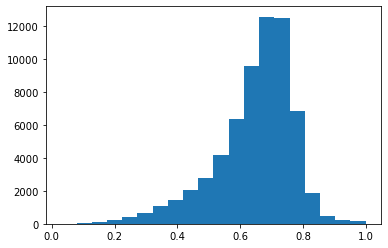

430/63672 questions >= 0.9


In [69]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(sample_cnn_article_generated_question_data.loc[:, 'best_question_score'], bins=20)
plt.show()
question_score_cutoff = 0.9
print(f'{sample_cnn_article_generated_question_data[sample_cnn_article_generated_question_data.loc[:, "best_question_score"] >= question_score_cutoff].shape[0]}/{sample_cnn_article_generated_question_data.shape[0]} questions >= {question_score_cutoff}')

OK! We have ~ 3% of generated questions that match the actual question. We should try to increase that!

### Re-train question model
Let's try to fine-tune the model using the training procedure explained [here](https://github.com/patil-suraj/question_generation#training). We should try to get the model to learn some of the basic logic required to put questions together for the CNN data before moving on prematurely to the NYT data.

In [1]:
## reload data fml
import pandas as pd
cnn_article_question_data = pd.read_csv('../../data/CNN_articles/cnn/article_question_data.tsv', sep='\t', index_col=False)
display(cnn_article_question_data.head())

,article_id,question,is_answer_absent,is_question_bad,article_text,question_tokens,article_tokens,publisher,dummy_comment_id,article_question_bleu
0,42d01e187213e86f5fe617fe32e716ff7fa3afc4,What was the amount of children murdered?,0.0,0.0,"NEW DELHI, India (CNN) -- A high court in nort...","['What', 'was', 'the', 'amount', 'of', 'childr...","['NEW', 'DELHI', ',', 'India', '(', 'CNN', ')'...",CNN,0,0.017422
1,42d01e187213e86f5fe617fe32e716ff7fa3afc4,When was Pandher sentenced to death?,0.0,0.0,"NEW DELHI, India (CNN) -- A high court in nort...","['When', 'was', 'Pandher', 'sentenced', 'to', ...","['NEW', 'DELHI', ',', 'India', '(', 'CNN', ')'...",CNN,1,0.017422
2,42d01e187213e86f5fe617fe32e716ff7fa3afc4,The court aquitted Moninder Singh Pandher of w...,0.0,0.0,"NEW DELHI, India (CNN) -- A high court in nort...","['The', 'court', 'aquitted', 'Moninder', 'Sing...","['NEW', 'DELHI', ',', 'India', '(', 'CNN', ')'...",CNN,2,0.020906
3,42d01e187213e86f5fe617fe32e716ff7fa3afc4,What was Moninder Singh Pandher acquitted for?,0.0,0.0,"NEW DELHI, India (CNN) -- A high court in nort...","['What', 'was', 'Moninder', 'Singh', 'Pandher'...","['NEW', 'DELHI', ',', 'India', '(', 'CNN', ')'...",CNN,3,0.020906
4,42d01e187213e86f5fe617fe32e716ff7fa3afc4,Who was sentenced to death in February?,0.0,0.0,"NEW DELHI, India (CNN) -- A high court in nort...","['Who', 'was', 'sentenced', 'to', 'death', 'in...","['NEW', 'DELHI', ',', 'India', '(', 'CNN', ')'...",CNN,4,0.020906


In [2]:
import os
# https://github.com/patil-suraj/question_generation/blob/master/prepare_data.py
class DataProcessor:
    """
    Process data for conversion to matrix format.
    """
    def __init__(self, tokenizer, model_type="t5", max_source_length=512, max_target_length=32):
        self.tokenizer = tokenizer
        self.max_source_length = max_source_length
        self.max_target_length = max_target_length
        self.model_type = model_type
        self.hl_token = "<hl>"
        
        if model_type == "t5":
            self.sep_token = "<sep>"
        elif model_type == "bart":
            self.sep_token = "<sep>"
        else:
            self.sep_token = "[SEP]"
  
    def process(self, dataset):
        if self.model_type == "t5":
            dataset = dataset.map(self._add_eos_examples)
        
        dataset = dataset.map(self._add_special_tokens)
        dataset = dataset.map(self._convert_to_features, batched=True)
        
        return dataset
  
    def _add_eos_examples(self, example):
        example['source_text'] = example['source_text'] + " </s>"
        example['target_text'] = example['target_text'] + " </s>"
        return example
  
    def _add_special_tokens(self, example):
        example['source_text'] = example['source_text'].replace("{hl_token}", self.hl_token)    
        example['target_text'] = example['target_text'].replace("{sep_token}", self.sep_token)
        return example
  
    # tokenize the examples
    def _convert_to_features(self, example_batch):
        source_encoding = self.tokenizer.batch_encode_plus(
            example_batch['source_text'],
            max_length=self.max_source_length,
            padding='max_length',
            pad_to_max_length=True,
            truncation=True, 
        )
        target_encoding = self.tokenizer.batch_encode_plus(
            example_batch['target_text'],
            max_length=self.max_target_length,
            padding='max_length',
            pad_to_max_length=True,
            truncation=True, 
        )

        encodings = {
            'source_ids': source_encoding['input_ids'], 
            'target_ids': target_encoding['input_ids'],
            'attention_mask': source_encoding['attention_mask'],
        }

        return encodings

import torch
import numpy as np
    
def prepare_question_data(data, out_dir, tokenizer, train_pct=0.8):
    # change to clean source/target format
    clean_data = data.loc[:, ['article_text', 'question']].rename(columns={'article_text' : 'source_text', 'question' : 'target_text'})
    # split train/val
    np.random.seed(123)
    N = clean_data.shape[0]
    N_train = int(N*train_pct)
    np.random.shuffle(clean_data.values)
    clean_data_train = clean_data.iloc[:N_train, :]
    clean_data_val = clean_data.iloc[N_train:, :]
    clean_data_train_out_file = os.path.join(out_dir, 'article_question_generation_train_data.csv')
    clean_data_val_out_file = os.path.join(out_dir, 'article_question_generation_val_data.csv')
    clean_data_train.to_csv(clean_data_train_out_file, sep=',', index=False)
    clean_data_val.to_csv(clean_data_val_out_file, sep=',', index=False)
    # reload data into correct format lol
    train_data_set = nlp.load_dataset('csv', data_files=clean_data_train_out_file)
    val_data_set = nlp.load_dataset('csv', data_files=clean_data_val_out_file)
#     tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
    # get max lengths
    source_text_tokens = clean_data.loc[:, 'source_text'].apply(lambda x: tokenizer.tokenize(x))
    target_text_tokens = clean_data.loc[:, 'target_text'].apply(lambda x: tokenizer.tokenize(x))
#     max_source_length = max(source_text_tokens.apply(lambda x: len(x)))
#     max_target_length = max(target_text_tokens.apply(lambda x: len(x)))
    # tmp debugging: shorten source/target
    max_source_length = 1024
    max_target_length = 64
    data_processor = DataProcessor(tokenizer=tokenizer,
                                   model_type='bert',
                                   max_source_length=max_source_length,
                                   max_target_length=max_target_length)
    train_data = data_processor.process(train_data_set)
    val_data = data_processor.process(val_data_set)
    columns = ["source_ids", "target_ids", "attention_mask"]
    train_data.set_format(type='torch', columns=columns)
    val_data.set_format(type='torch', columns=columns)
#     print(f'train data {train_data}')
    train_data_out_file = os.path.join(out_dir, 'article_question_generation_train_data.pt')
    val_data_out_file = os.path.join(out_dir, 'article_question_generation_val_data.pt')
    torch.save(train_data, train_data_out_file)
    torch.save(val_data, val_data_out_file)
    # save tokenizer?? sure
    tokenizer_out_file = os.path.join(out_dir, 'BART_tokenizer.pt')
    torch.save(tokenizer, tokenizer_out_file)

In [3]:
import nlp
import transformers
from transformers import BartTokenizer
out_dir = '../../data/CNN_articles/cnn/'
train_pct = 0.8
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
# TODO: increase vocab size to include named entities? 
# TODO: shrink data to debug training
prepare_question_data(cnn_article_question_data.copy().head(1000), out_dir, tokenizer=tokenizer, train_pct=train_pct)

Using custom data configuration default
Using custom data configuration default


Now let's train a model to generate the questions.

In [1]:
# stolen from https://github.com/patil-suraj/question_generation/blob/master/run_qg.py
import sys
if('question-generation' not in sys.path):
    sys.path.append('question-generation')
import torch
# load models
from transformers import BertModel, BertTokenizer, BartTokenizer, AutoModelForSeq2SeqLM
cache_dir = '../../data/CNN_articles/cnn/model_cache/'
model = BertModel.from_pretrained('bert-base-cased')
# tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
tokenizer = torch.load('../../data/CNN_articles/cnn/BART_tokenizer.pt')
# print(len(tokenizer))
model = AutoModelForSeq2SeqLM.from_pretrained(
        'facebook/bart-base',
        cache_dir=cache_dir,
    )
model.resize_token_embeddings(len(tokenizer))
device = torch.device('cuda:0')
model.to(device)

## load data
import os
data_dir = '../../data/CNN_articles/cnn/'
train_file = os.path.join(data_dir, 'article_question_generation_train_data.pt')
val_file = os.path.join(data_dir, 'article_question_generation_val_data.pt')
train_dataset = torch.load(train_file)
val_dataset = torch.load(val_file)
train_dataset = train_dataset['train']
val_dataset = val_dataset['train']

# get max source/target len
max_source_len = len(train_dataset['source_ids'][0])
max_target_len = len(train_dataset['target_ids'][0])

# initialize data collator
import sys
if('question_generation' not in sys.path):
    sys.path.append('question_generation')
from data_collator import T2TDataCollator
model_type = 'bart'
data_collator = T2TDataCollator(
    tokenizer=tokenizer,
    model_type=model_type,
    mode="training",
    using_tpu=False
)
# #  Initialize Trainer
# need data argument class ;_;
from dataclasses import field
from typing import Dict, List, Optional
from transformers.training_args import TrainingArguments
class DataArguments(TrainingArguments):
    train_file_path: str = field(
        metadata={"help": "Path for cached train dataset"},
    )
    valid_file_path: str = field(
        metadata={"help": "Path for cached valid dataset"},
    )
    data_dir: Optional[str] = field(
        default=None,
        metadata={"help": "Path for data files"}, 
    )
    task: Optional[str] = field(
        default=None,
        metadata={"help": "Which task 'qa', 'qg', 'e2e_qg', 'ans_ext', 'multi'. 'multi' means 'qa', 'qg', 'ans_ext' tasks"}, 
    )
    qg_format: Optional[str] = field(
        default='prepend_qg_format',
        metadata={"help": "How to format inputs for que generation, 'highlight_qg_format' or 'prepend_qg_format'"}, 
    )
    max_source_length: Optional[int] = field(
        default=512,
        metadata={"help": "Max input length for the source text"},
    )
    max_target_length: Optional[int] = field(
        default=32,
        metadata={"help": "Max input length for the target text"},
    )
    n_gpu : Optional[int] = field(
        default=1,
    )
# training_arg_dict = {
#     'train_file_path' : 'article_question_generation_train_data.pt',
#     'valid_file_path' : 'article_question_generation_val_data.pt',
#     'data_dir' : data_dir,
#     'task' : 'qg',
#     'max_source_length' : max_source_len,
#     'max_target_length' : max_target_len,
#     'n_gpu' : 1,
#     'seed' : 123,
# }
data_dir = '../../data/CNN_articles/cnn/'
out_dir = '../../data/CNN_articles/cnn/question_generation_model/'
import os
if(not os.path.exists(out_dir)):
    os.mkdir(out_dir)
training_args = DataArguments(out_dir)
training_args.train_file_path = 'article_question_generation_train_data.pt',
training_args.valid_file_path = 'article_question_generation_val_data.pt'
training_args.data_dir = data_dir
training_args.task = 'qg'
training_args.max_source_length = max_source_len
training_args.max_target_length = max_target_len
training_args.n_gpu = 1 
# training_args.device = 'cuda:1' 
training_args.seed = 123
training_args.disable_tqdm = False
training_args.local_rank = -1
training_args.output_dir = out_dir
training_args.num_train_epochs = 20
# training_args.max_steps = 1
training_args.fp16 = False
training_args.label_names = None
training_args.per_device_train_batch_size = 4
training_args.per_device_eval_batch_size = 4
# training_args.train_batch_size = 32
# training_args.eval_batch_size = 32
training_args.gradient_accumulation_steps = 4
training_args.learning_rate = 1e-4
training_args.dataloader_drop_last = False
training_args.dataloader_num_workers = 8
# default values from here lol https://github.com/huggingface/transformers/blob/49759c0cda29ab614b81e0869972c99f2edba7aa/src/transformers/training_args.py
training_args.weight_decay = 0.01
training_args.adam_beta1 = 0.9
training_args.adam_beta2 = 0.999
training_args.adam_epsilon = 1e-8
training_args.warmup_steps = 0
# limits number of checkpoints => 1 GB per optimizer file ;_;
training_args.total_save_limit = 2
model_args = {
    'label_smoothing' : 0,
}
## TODO: prevent model from saving optimizer during every 500 training steps!!
from trainer import Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
#     prediction_loss_only=True,
    label_smoothing=model_args['label_smoothing'],
)

In [ ]:
## train
import torch
torch.cuda.empty_cache()
model_dir = '../../data/CNN_articles/cnn/question_generation_model/'
trainer.train(
    model_path=model_dir,
)
trainer.save_model()

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nlp/utils/py_utils.py:191: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return function(data_struct)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nlp/utils/py_utils.py:191: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning w

Step,Training Loss


/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nlp/utils/py_utils.py:191: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return function(data_struct)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nlp/utils/py_utils.py:191: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning w

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nlp/utils/py_utils.py:191: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return function(data_struct)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nlp/utils/py_utils.py:191: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning w

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nlp/utils/py_utils.py:191: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return function(data_struct)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nlp/utils/py_utils.py:191: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning w

In [ ]:
## evaluate
# eval_output = trainer.evaluate()
# output_eval_file = os.path.join(training_args.output_dir, "eval_results.txt")
# with open(output_eval_file, "w") as writer:
#     logger.info("***** Eval results *****")
#     for key in sorted(eval_output.keys()):
#         logger.info("  %s = %s", key, str(eval_output[key]))
#         writer.write("%s = %s\n" % (key, str(eval_output[key])))

In [9]:
print(dir(trainer))
print(dir(trainer.optimizer))
print(trainer.optimizer._step_count)

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_actual_model', '_gather_and_numpify', '_get_eval_sampler', '_get_train_sampler', '_globalstep_last_logged', '_hp_search_setup', '_load_optimizer_and_scheduler', '_loggers_initialized', '_logging_loss_scalar', '_maybe_log_save_evaluate', '_prepare_inputs', '_remove_unused_columns', '_report_to_hp_search', '_rotate_checkpoints', '_save', '_save_checkpoint', '_save_tpu', '_sorted_checkpoints', '_total_flos', '_training_step', '_trial', '_tune_save_checkpoint', 'add_callback', 'args', 'call_model_init', 'callback_handler', 'compute_loss', 'compute_metrics', 'control', 'create_optimizer_and_scheduler', 'data_collator', 'eval_dataset', 'evaluate', 'fl

### Test question generation: user-generated questions
Let's see how well we can generate the same questions that people ask on NYT articles. It may be that the current model can't anticipate information gaps!!